In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet



import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'consumption' is your target variable
df = pd.read_csv('wheaterVersion.csv')

df.head()

c:\Users\Stijn\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


,datetime,Customer,Generator Capacity,Postcode,Consumption Category,consumption,temperature_2m,precipitation,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,is_day,sunshine_duration
0,2010-07-01 00:00:00,201,1.75,2291,GG,0.000,24.0,0.0,35.1,12.0,0.0,81.0,1.0,3600.0
1,2010-07-01 00:00:00,36,1.00,2137,GG,0.000,24.0,0.0,35.1,12.0,0.0,81.0,1.0,3600.0
2,2010-07-01 00:00:00,36,1.00,2137,CL,2.209,24.0,0.0,35.1,12.0,0.0,81.0,1.0,3600.0
3,2010-07-01 00:00:00,36,1.00,2137,GC,0.191,24.0,0.0,35.1,12.0,0.0,81.0,1.0,3600.0
4,2010-07-01 00:00:00,35,2.10,2284,GG,0.000,24.0,0.0,35.1,12.0,0.0,81.0,1.0,3600.0


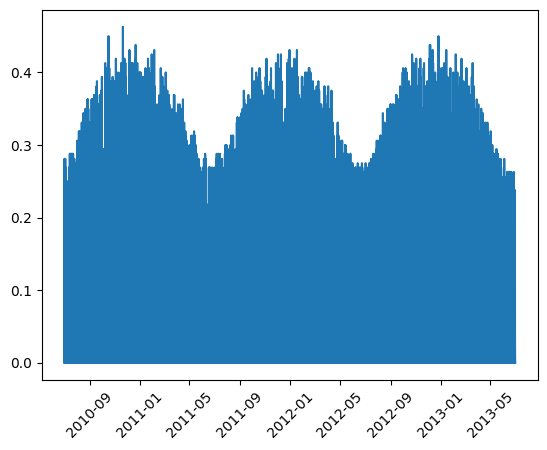

In [2]:
from dask.distributed import Client
client = Client()
df['datetime'] = pd.to_datetime(df['datetime'])



#creat a subset only for customer 36
customer_36 = df[df['Customer'] == 36]

customer_36 = customer_36[customer_36['Consumption Category'] == 'GG']

#only keep datetime month, day of the week and consumption columns
customer_36 = customer_36[['datetime', 'consumption']]




customer_36.head()

plt.plot(customer_36['datetime'], customer_36['consumption'])
plt.xticks(rotation=45)
plt.show()



In [3]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

# Prophet requires columns ds (Date) and y (value)
customer_36 = customer_36.rename(columns={'datetime': 'ds', 'consumption': 'y'})
customer_36['cap'] = customer_36['y'].max()


m = Prophet(seasonality_prior_scale=10,daily_seasonality=True,yearly_seasonality=True  ,seasonality_mode='multiplicative',growth='logistic')


m.fit(customer_36)


customer_36.tail()


19:58:25 - cmdstanpy - INFO - Chain [1] start processing
19:58:29 - cmdstanpy - INFO - Chain [1] done processing


,ds,y,cap
19403074,2013-06-30 19:00:00,0.0,0.463
19403813,2013-06-30 20:00:00,0.0,0.463
19404549,2013-06-30 21:00:00,0.0,0.463
19405289,2013-06-30 22:00:00,0.0,0.463
19406026,2013-06-30 23:00:00,0.0,0.463


In [6]:
%pip install distributed
%pip install dask


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:

future = m.make_future_dataframe(periods=7, freq='H')
future['cap'] = customer_36['y'].max()  # Use the same cap as in the historical data
forecast = m.predict(future)

# Create a Dask client


# Perform cross-validation with Dask parallelization
df_cv = cross_validation(m, initial='500 days', period='7 days', horizon='7 days', parallel="dask")

# Display the head of the cross-validation DataFrame
df_cv.head()


c:\Users\Stijn\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-11-14 00:00:00,0.008117,-0.066308,0.078391,0.0,2011-11-13 23:00:00
1,2011-11-14 01:00:00,0.012522,-0.056432,0.092475,0.0,2011-11-13 23:00:00
2,2011-11-14 02:00:00,0.019630,-0.052391,0.094217,0.0,2011-11-13 23:00:00
3,2011-11-14 03:00:00,0.019702,-0.062660,0.090338,0.0,2011-11-13 23:00:00
4,2011-11-14 04:00:00,0.009779,-0.063425,0.088926,0.0,2011-11-13 23:00:00


                   ds      yhat  yhat_lower  yhat_upper    y  \
0 2011-11-14 00:00:00  0.008117   -0.066308    0.078391  0.0   
1 2011-11-14 01:00:00  0.012522   -0.056432    0.092475  0.0   
2 2011-11-14 02:00:00  0.019630   -0.052391    0.094217  0.0   
3 2011-11-14 03:00:00  0.019702   -0.062660    0.090338  0.0   
4 2011-11-14 04:00:00  0.009779   -0.063425    0.088926  0.0   

               cutoff  
0 2011-11-13 23:00:00  
1 2011-11-13 23:00:00  
2 2011-11-13 23:00:00  
3 2011-11-13 23:00:00  
4 2011-11-13 23:00:00  
False


c:\Users\Stijn\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\Stijn\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\Stijn\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = f

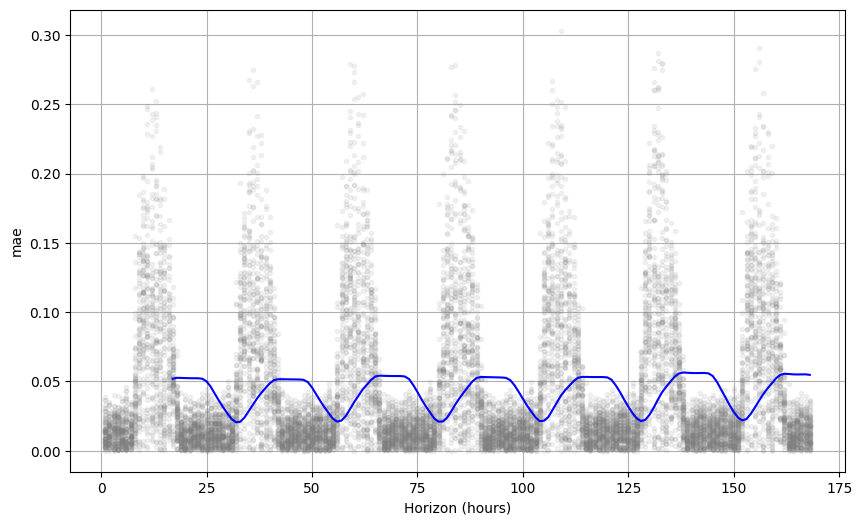

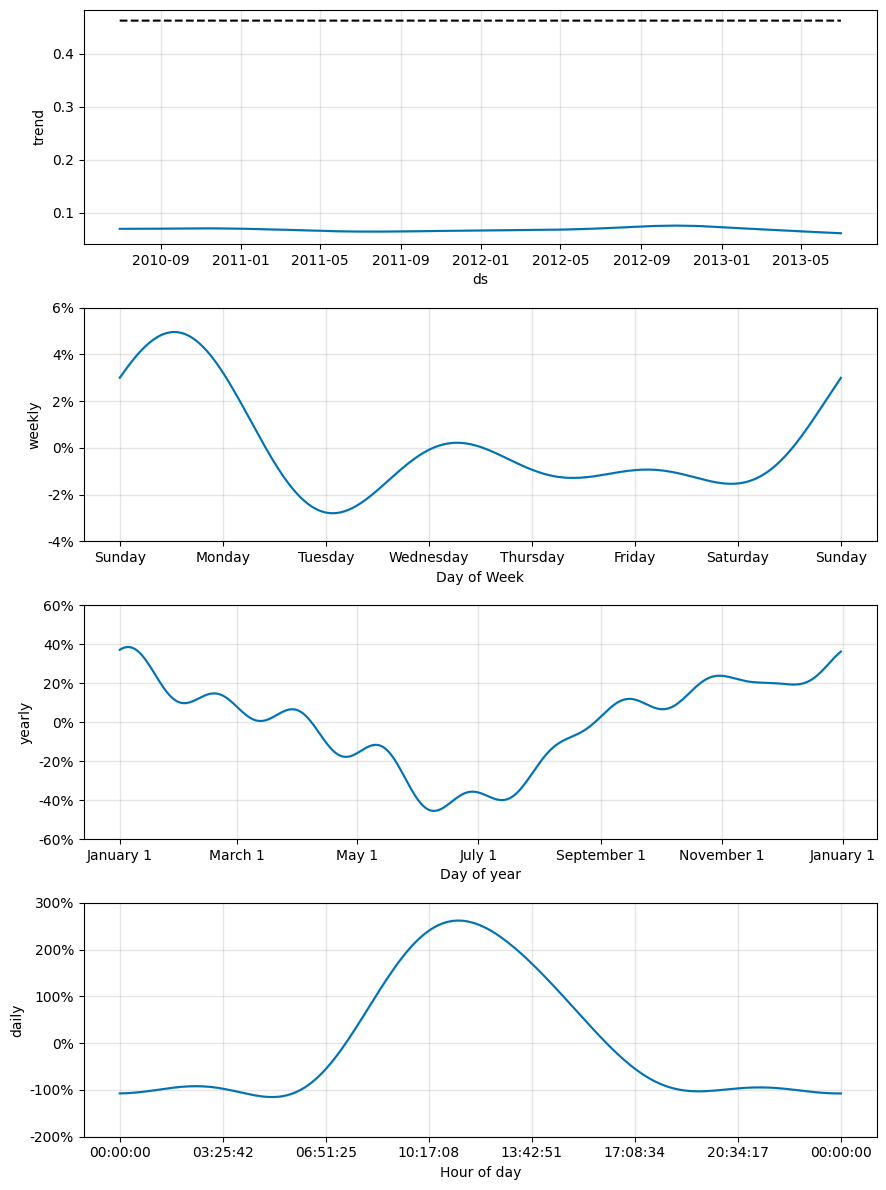

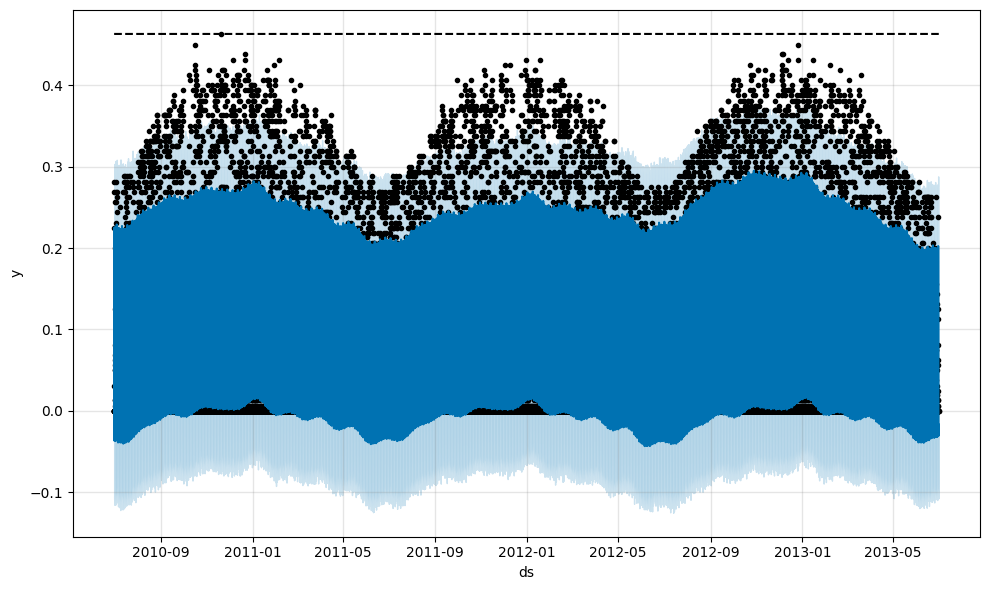

In [6]:
print(df_cv.head())
print('horizon' in df_cv.columns)


# Calculate performance metrics
df_p = performance_metrics(df_cv)

# Plot performance metrics
fig = plot_cross_validation_metric(df_cv, metric='mae')  # Mean Absolute Percentage Error

fig2 = m.plot_components(forecast)

# Plot the forecast
fig1 = m.plot(forecast)

plt.show()

In [8]:
import pandas as pd
import itertools
import logging

# Set up logging
logging.basicConfig(filename='tuning.log', level=logging.INFO, format='%(asctime)s %(message)s')

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'growth': ['logistic','linear'],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_range': [0.8, 0.9],
    'n_changepoints': [20, 25, 30]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

cutoffs = pd.date_range(start=customer_36['ds'].min() + pd.Timedelta('7 days'), end=customer_36['ds'].max() - pd.Timedelta('7 days'), freq='30D')

# Use cross validation to evaluate all parameters
for i, params in enumerate(all_params):
    logging.info(f'Starting cross-validation for parameters {params}')
    m = Prophet(**params).fit(customer_36)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='7 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmse = df_p['rmse'].values[0]
    rmses.append(rmse)
    logging.info(f'Finished cross-validation for parameters {params}, RMSE: {rmse}')

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

logging.info('Finished all cross-validations')

2024-04-17 18:41:36,925 - distributed.utils_perf - WARNING - full garbage collections took 62% CPU time recently (threshold: 10%)
18:41:38 - cmdstanpy - INFO - Chain [1] start processing
18:41:39 - cmdstanpy - INFO - Chain [1] done processing


KeyboardInterrupt: 

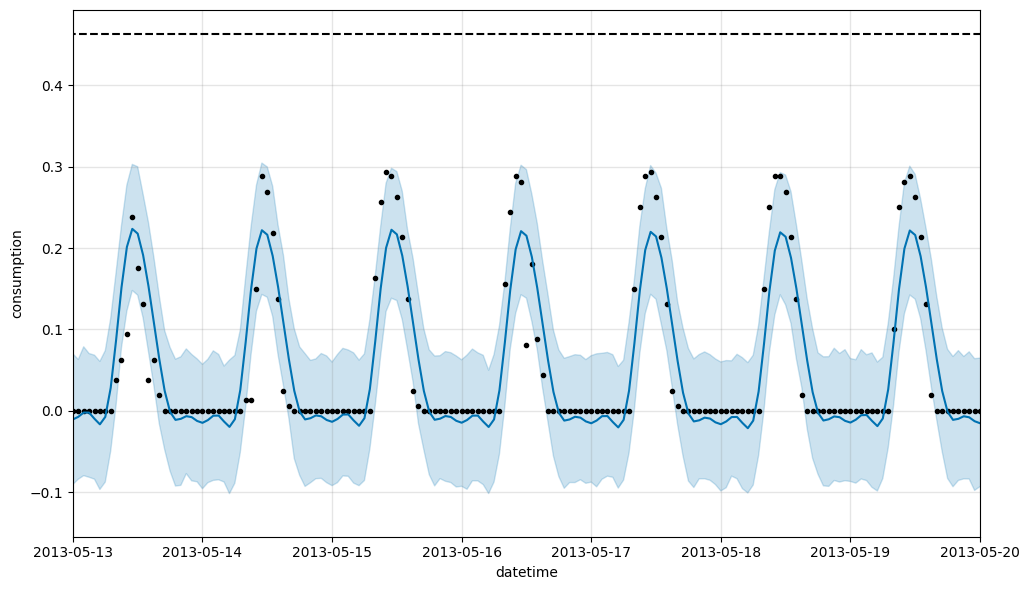

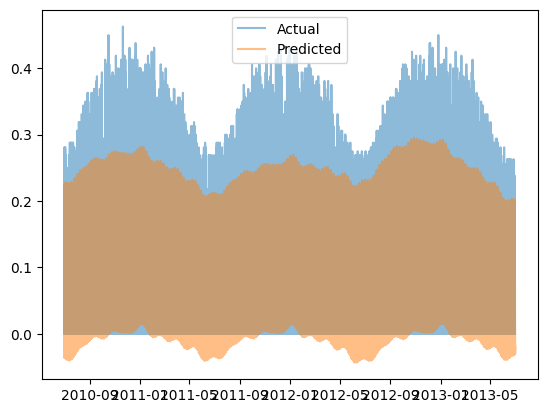

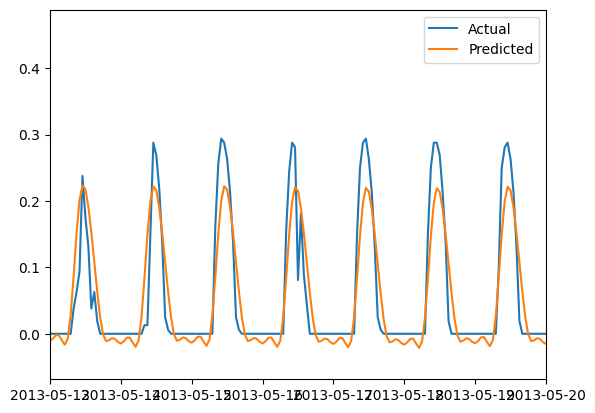

26304
26311
26304


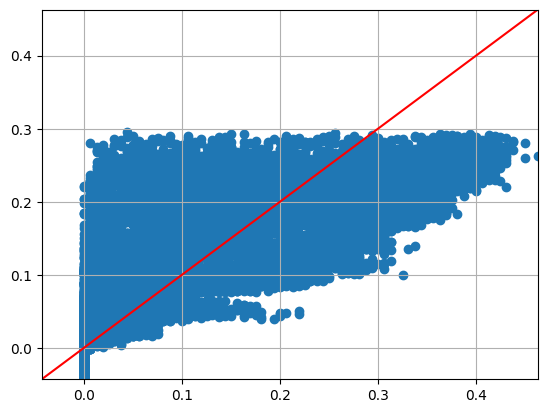

In [8]:
#only show a week of the forecast
fig2 = m.plot(forecast, xlabel='datetime', ylabel='consumption')
plt.xlim(pd.Timestamp('2013-05-13'), pd.Timestamp('2013-05-20'))
plt.show()

# Plot both the actual data and the forecast with semi-transparency
plt.plot(customer_36['ds'], customer_36['y'], alpha=0.5)
plt.plot(forecast['ds'], forecast['yhat'], alpha=0.5)

# Add a legend
plt.legend(['Actual', 'Predicted'])

# Show the plot
plt.show()

#plot a week of acutal data and forecast
plt.plot(customer_36['ds'], customer_36['y'])
plt.plot(forecast['ds'], forecast['yhat'])
plt.xlim(pd.Timestamp('2013-05-13'), pd.Timestamp('2013-05-20'))
plt.legend(['Actual', 'Predicted'])
plt.show()


#get the length of the data
print(len(customer_36))
print(len(forecast))
#drop the last 7 values from the forecast
forecast = forecast[:-7]
print(len(forecast))

# Create scatter plot of actual vs predicted
plt.scatter(customer_36['y'], forecast['yhat'])

# Get the limits for x and y axes
lower_limit = min(min(customer_36['y']), min(forecast['yhat']))
upper_limit = max(max(customer_36['y']), max(forecast['yhat']))

# Set the same scale for both x and y axes
plt.xlim(lower_limit, upper_limit)
plt.ylim(lower_limit, upper_limit)

# Draw a 45-degree line
plt.plot([lower_limit, upper_limit], [lower_limit, upper_limit], 'r')

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

